# 2110443 - Computer Vision (2020/2)
## Lab 6 - Simple Object Recognition
In this lab, we will learn to use useful  handcrafted features to recognize objects in the provied images. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer

<b>Collaboration is encouraged in this course.</b> You must turn in <b>your own write ups</b> of all problems. If you collaborate with others, you must put the names and ids of the students you worked with in below block.

Collaboration List:
- ...
- ...

In [2]:
import cv2
import math
import numpy as np
import random as rng
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display, HTML,clear_output
%matplotlib inline

## Maker Based Segmentation

In this section, we will learn how to apply a classic segmentation algorithm named <b>watershed</b>. This algorithm can be used to detect and extract objects in images that are <b>touching and/or overlapping</b> (like RBC in previous Lab!).

Assume that we want to build an application to count coins value from the following image. First of all, we need to segment each coins in to a individual connected component.

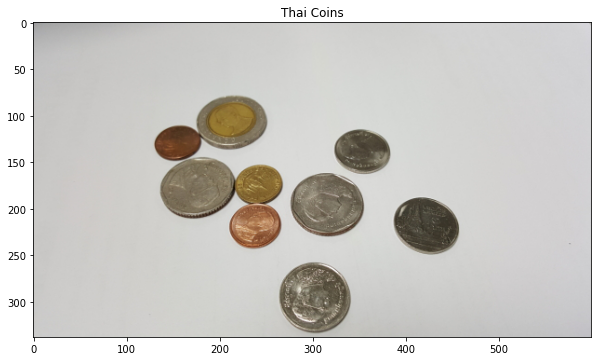

In [3]:
sampleCoinImage = cv2.imread("assets/Lab6-SampleCoins.jpg")
sampleCoinGray = cv2.cvtColor(sampleCoinImage,cv2.COLOR_BGR2GRAY)
tempImage = cv2.cvtColor(sampleCoinImage,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.title("Thai Coins")
plt.imshow(tempImage)
plt.show()

The following blocks try to use edge information from previous lecture to seperate coins image into individual coin.
Standard Sobel operator is used to extract edge information and only strong edge pixels are kept based on defined threshold. Try to adjust the edge threshold value to seperate each coin from others

In [4]:
def extractSobelEdge(thresholdEdgeVal):
    sampleCoinGrayBlur = cv2.blur(sampleCoinGray,(15,15))
    sobelX = np.uint8(np.absolute(cv2.Sobel(sampleCoinGrayBlur,cv2.CV_64F,1,0,ksize=3)))
    sobelY = np.uint8(np.absolute(cv2.Sobel(sampleCoinGrayBlur,cv2.CV_64F,0,1,ksize=3)))
    sobelXY = (sobelX + sobelY) > thresholdEdgeVal
    plt.figure(figsize=(10,10))
    plt.title("Edge Image")
    plt.imshow(sobelXY,cmap='gray')
    plt.show()
interact(extractSobelEdge, thresholdEdgeVal=widgets.IntSlider(min=0,max=255,step=1,value=1));

interactive(children=(IntSlider(value=1, description='thresholdEdgeVal', max=255), Output()), _dom_classes=('w…

You can see from the above threshold edge map, even we selects a precise edge threshold, we cannot segment connected coins into individual one. In order to use watershed algorithm, markers muse be place at the corresponded location of the objects in our image. The markers can be either manual define or calculate from various image processing techniques. We will start from using <a href="https://docs.opencv.org/3.4.2/d7/d4d/tutorial_py_thresholding.html">automatic Otsu thesholding</a>.

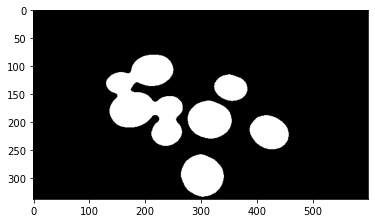

In [5]:
sampleCoinGrayBlur = cv2.medianBlur(sampleCoinGray, 13)
_,thresholdCoinImage = cv2.threshold(sampleCoinGrayBlur,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.imshow(thresholdCoinImage, cmap='gray')
plt.show()

This image gray levels can be visualized as follows

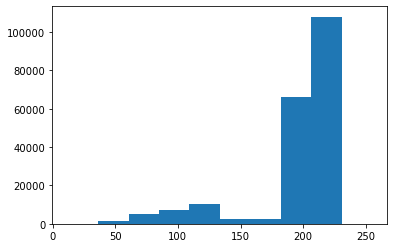

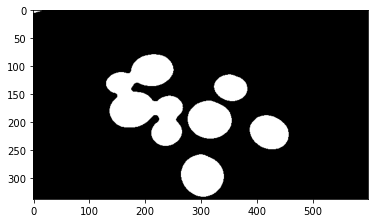

In [6]:
plt.hist(sampleCoinGray.flatten())
plt.show()

plt.imshow(sampleCoinGrayBlur <165, cmap='gray') # we can manually select a proper theshold value to sperate between background and foreground
plt.show()

We then apply <a href="https://docs.opencv.org/3.4.2/d7/d1b/group__imgproc__misc.html#ga8a0b7fdfcb7a13dde018988ba3a43042">distance transform</a> to the thresholding output. Distance transform calculates the approximate or precise distance from every binary image pixel to the nearest zero pixel

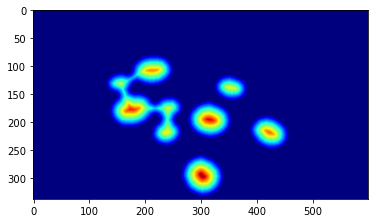

In [7]:
distanceTransformOutput = cv2.distanceTransform(thresholdCoinImage,cv2.DIST_L2, 3)
plt.imshow(distanceTransformOutput,cmap='jet')
plt.show()

Pick only pixel which is greater than 45% of max distance as potential coin markers.

Max Distance: 35.187332


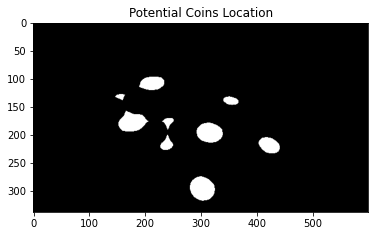

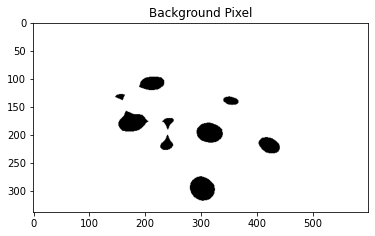

In [8]:
maxDistance = np.max(distanceTransformOutput)
print('Max Distance:',maxDistance)
roughMarkerPixel = np.uint8(distanceTransformOutput > 0.45 * maxDistance)
backgroundMask = np.invert(roughMarkerPixel)
plt.title('Potential Coins Location')
plt.imshow(roughMarkerPixel, cmap='gray')
plt.show()

plt.figure()
plt.title('Background Pixel')
plt.imshow(backgroundMask, cmap='gray')
plt.show()

Labeling each connected component with its unique label number by using <a href="https://docs.opencv.org/3.4.2/d3/dc0/group__imgproc__shape.html#gaedef8c7340499ca391d459122e51bef5">cv2.connectedComponents</a>.

Computes the connected components labeled image of boolean image
image with 4 or 8 way connectivity - returns N, the total number of labels [0, N-1] where 0 represents the background label

Min Label: 0 Max Label: 9


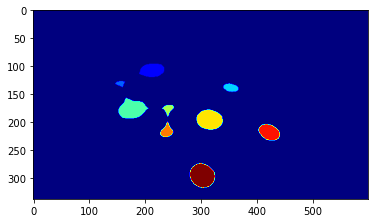

In [9]:
_, seed = cv2.connectedComponents(roughMarkerPixel)
print('Min Label:',np.min(seed),'Max Label:',np.max(seed))
plt.imshow(seed,cmap='jet')
plt.show()

In [10]:
seed[-10:,-10] = np.max(seed) + 1

Apply <a href="https://docs.opencv.org/3.4.2/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1">watershed algorithm</a> using created marker and input coins image. Is there any missing coin? Why? Fix the bug and state your instruction in below block.

Min Label: -1 Max Label: 10


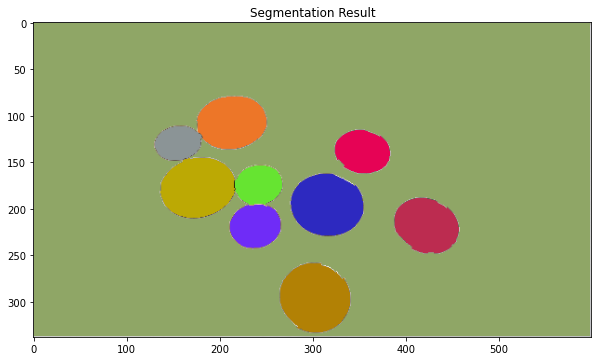

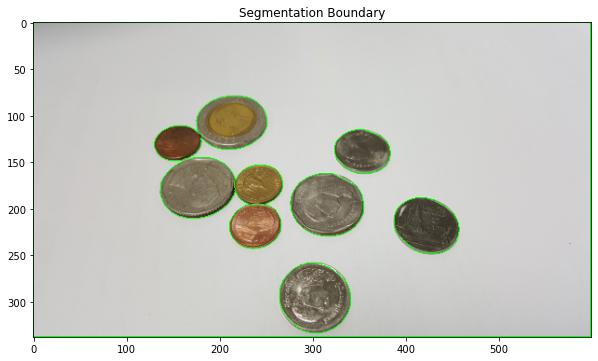

In [11]:
outputImage = sampleCoinImage.copy()
borderImage = sampleCoinImage.copy()
outputMarkers = cv2.watershed(outputImage,seed) ### Warning seed will get modified here!!
# -1 is border pixel  
print('Min Label:',np.min(outputMarkers),'Max Label:',np.max(outputMarkers))

# 1 is background 
for outputMarkerIdx in range(1,np.max(outputMarkers+1)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    outputImage[np.where(outputMarkers == outputMarkerIdx)] = color
outputImage = cv2.cvtColor(outputImage,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.title('Segmentation Result')
plt.imshow(outputImage)
plt.show()

borderImage[np.where(outputMarkers == -1)] = (0,255,0)
borderImage = cv2.cvtColor(borderImage,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.title('Segmentation Boundary')
plt.imshow(borderImage)
plt.show()

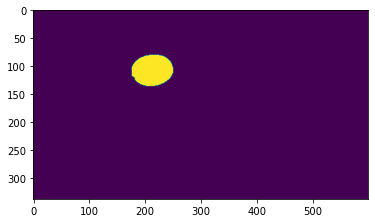

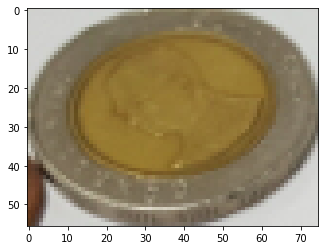

In [12]:
### Crop out individual coin
firstCointMask = outputMarkers == 1
plt.imshow(firstCointMask)
plt.show()

contour, _ = cv2.findContours(firstCointMask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

x,y,w,h = cv2.boundingRect(contour[0])

cropCoinBGR = sampleCoinImage[y:y+h,x:x+w,:]
cropCoinRGB = cv2.cvtColor(cropCoinBGR, cv2.COLOR_BGR2RGB)
plt.imshow(cropCoinRGB)
plt.show()

In [13]:
'''
How to find the missing coin?

tag background
'''

'\nHow to find the missing coin?\n\ntag background\n'

### Assignment 1 - Coin Counter

From the above section, we can gracefully segment overlpping coins! Your today task is to implement a program to count total coin value from test images provided in assets folder. Please include two of your own test images by using smartphone camera. The images should show robustness of your designed alogorithm such as overlapping coins, tilt camera angle or shadow handling. Don't forget to show your work in step in below block. <br>(Optional) You will get extra points if you can use <b>same parameters</b> for all test images. :)

<b>Remark : </b>
- There are four test images in assets folder. Please hand in the recognition result in image files. 
- You should not count outlier object (key)!!!

<b>Basic Guidance:<b>
1. Segment each coin into individual connected component and find the bounding box which can enclose those connect components by <a href="https://docs.opencv.org/3.4.2/d3/dc0/group__imgproc__shape.html#gacb413ddce8e48ff3ca61ed7cf626a366">cv2.boundingRect</a>
2. For each component, extract <b>useful features</b> (you have to design this by youself).
3. Classify those components into Thai Coin classes.  

<b>Hints:</b>
- How do to discard noise/fill small hole from segmentation mask output? (Previous Lab?)
- Smoothing input image before apply thresholding by using <a href="https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#ga8c45db9afe636703801b0b2e440fce37">cv2.blur</a>, <a href="https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9">cv2.medianFilter</a> or <a href="https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#ga9fabdce9543bd602445f5db3827e4cc0">cv2.pyrMeanShiftFiltering</a> might be able to improve threshold result.
- From the beginning of this class, you had learned many potential image features, such as edge, color, contour and shape. Use them wisely.
- Internet is your friend. You can search for relavent research papers and use their algorithm, but you must <b>give proper credits</b> by citing them in this notebook. 

### Describe how your algorithm work here (Thai or English). You can provide any visualization if you want.

#### Honestly, I'm not very proud of this assignment. Please forgive me.

#### segment coin
- thresh hold and do CLOSE opereator before segmentation of the coin as above suggest (watershed)

#### create feature vector
- convert image to hsv
- feature vector[0:199] = histogram of s component
- feature vector[200] = size ratio to one bath coin in image (top left)

#### classify
- feature vector on sample image are references
- on each coin on each image compare distance with the references
    - classify type of coin as the coin that have closest distance on reference
    - if the closest distance is too far classify as other

In [183]:
idx2coin = {
    1: 10,
    2: 0.5,
    3: 1,
    4: 5,
    5: 0.5,
    6: 5,
    7: 0.5,
    8: 1,
    9: 1
}


## Prepare reference vector

8
2129


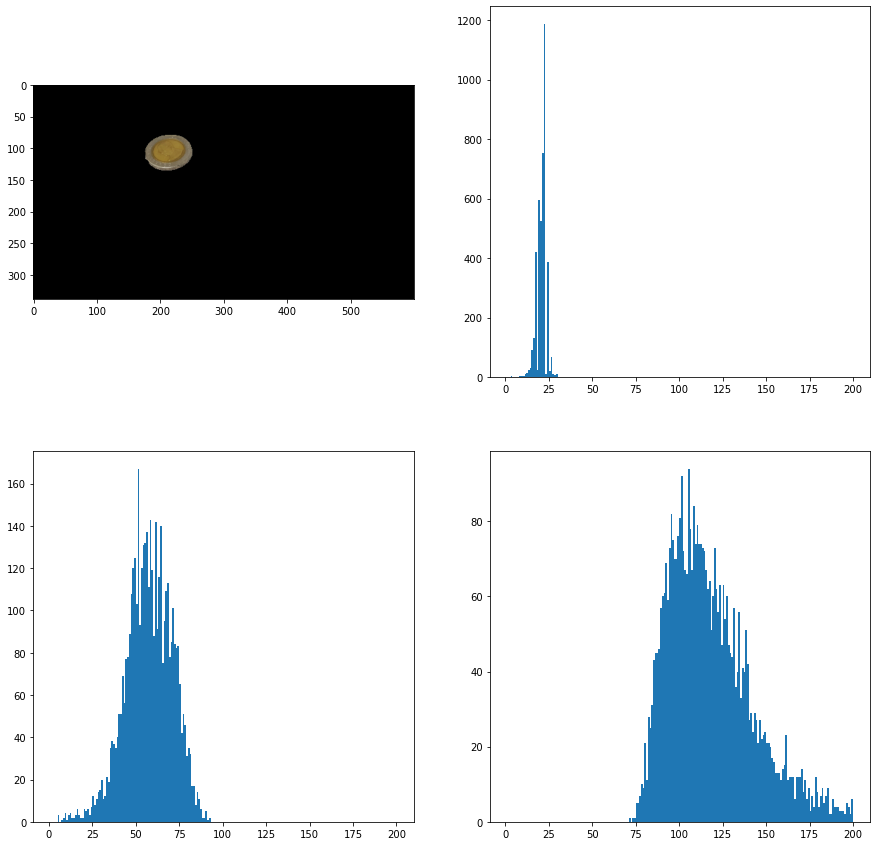

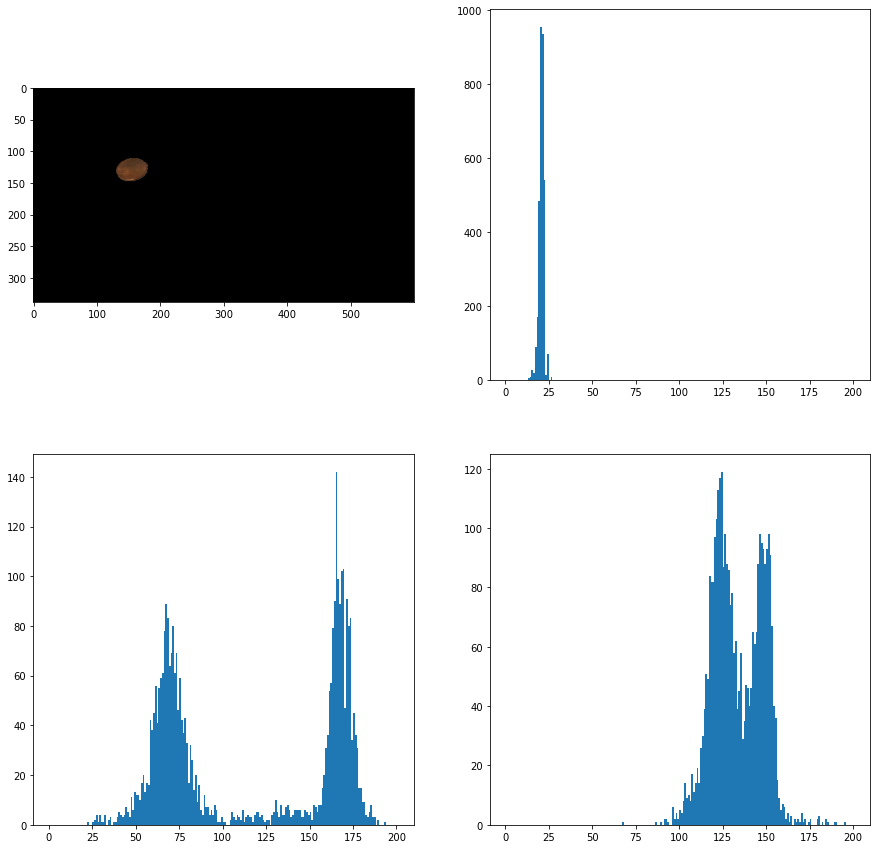

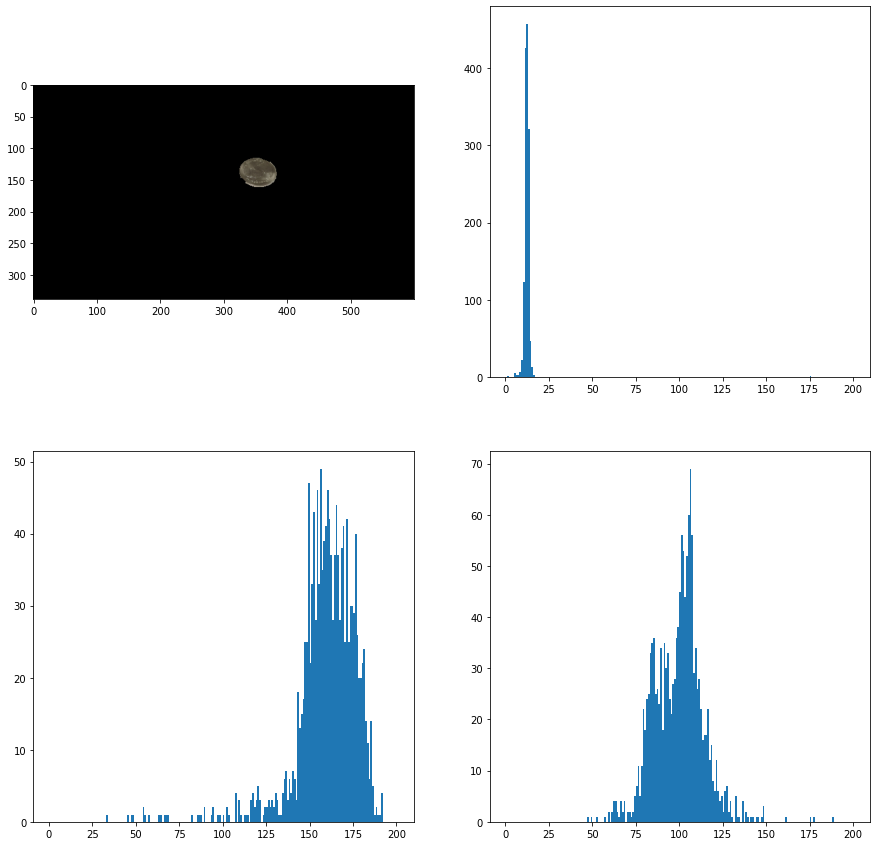

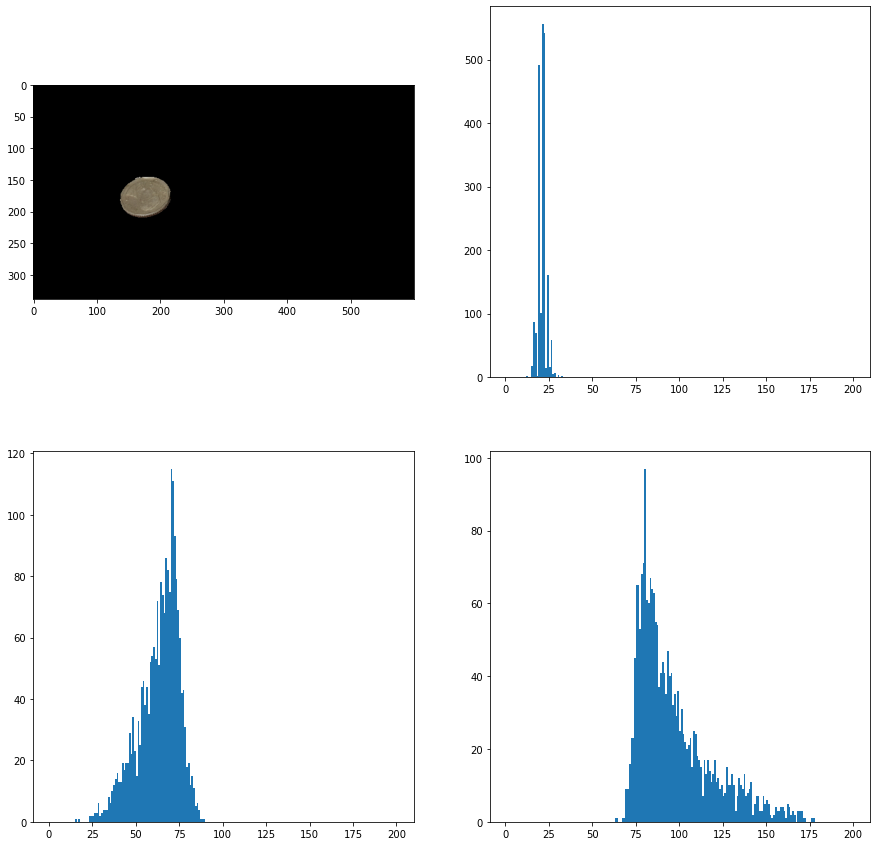

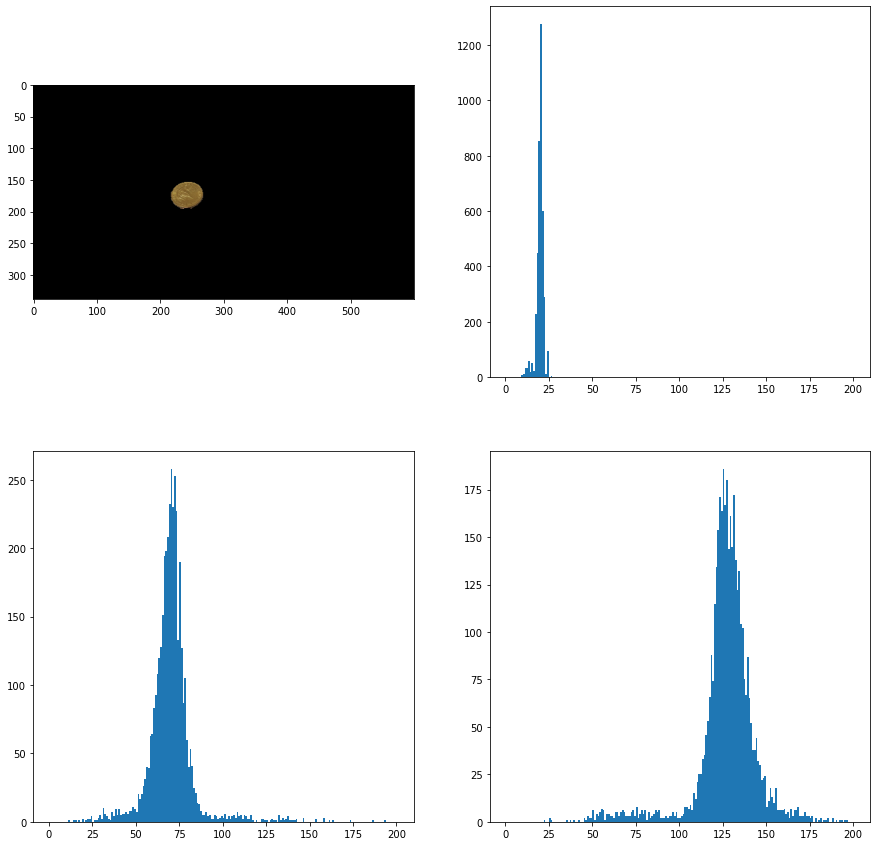

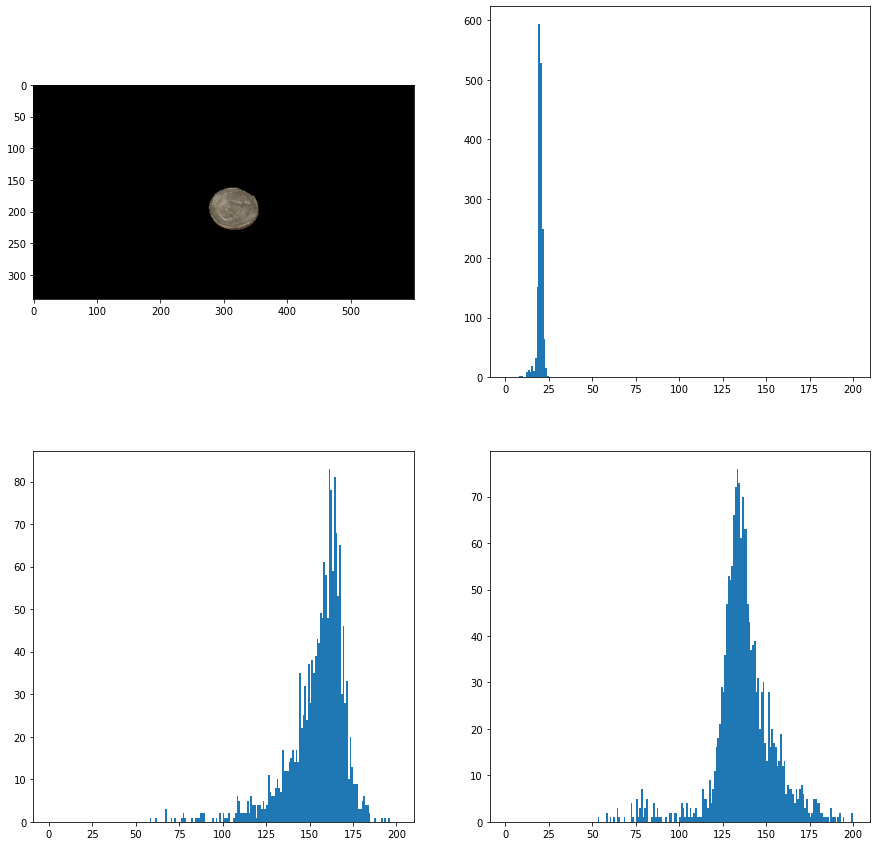

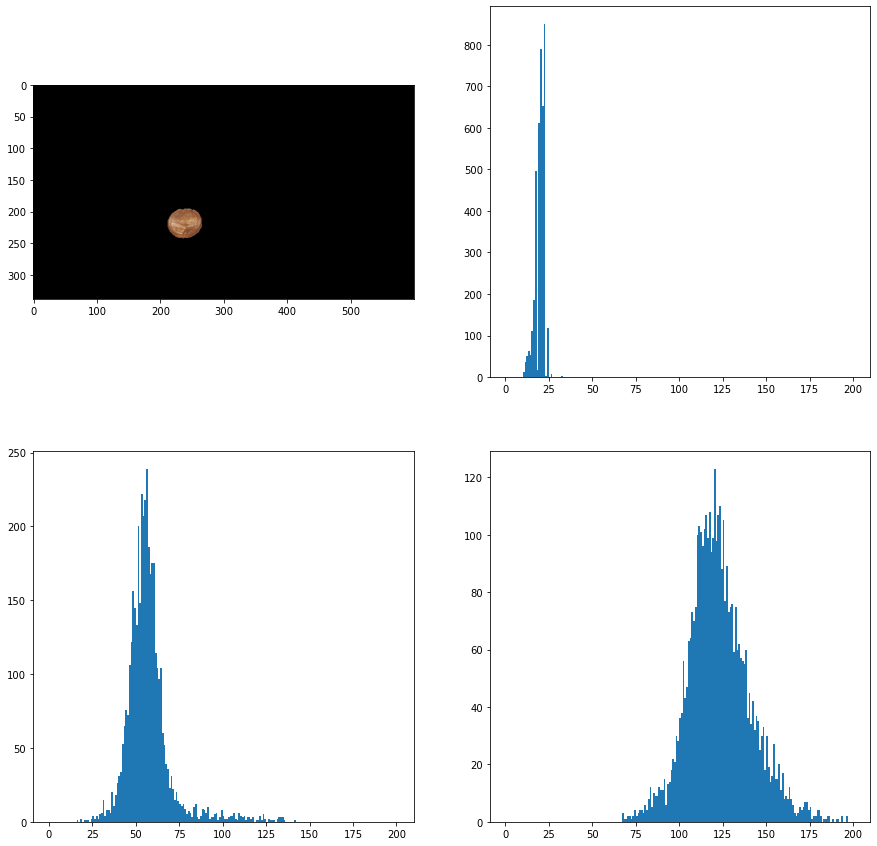

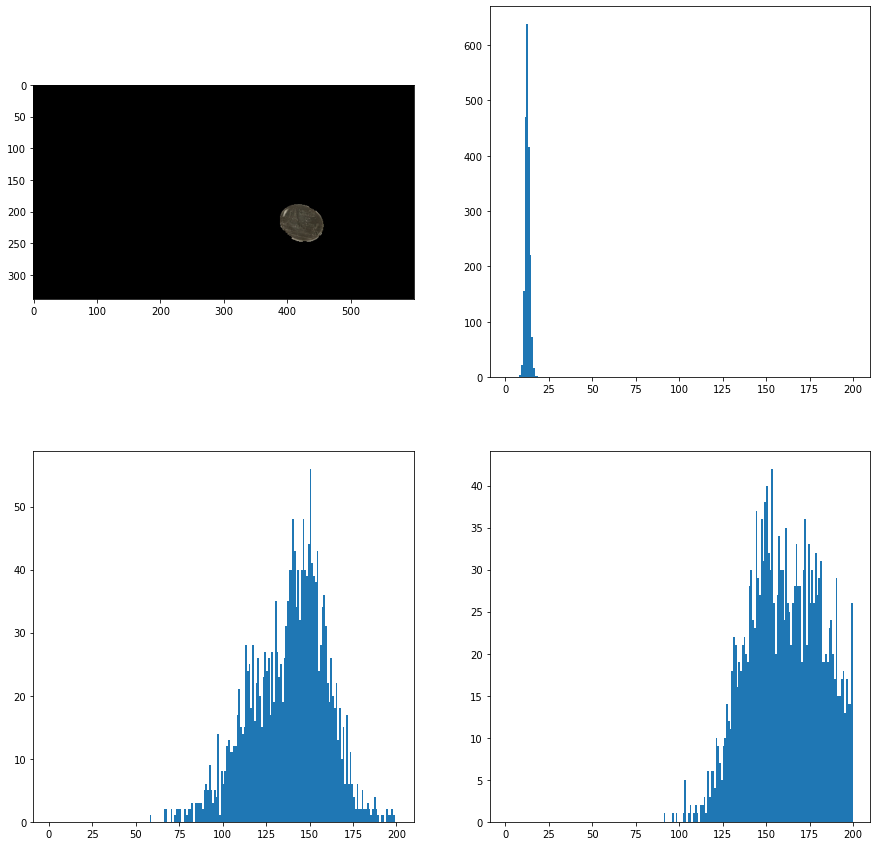

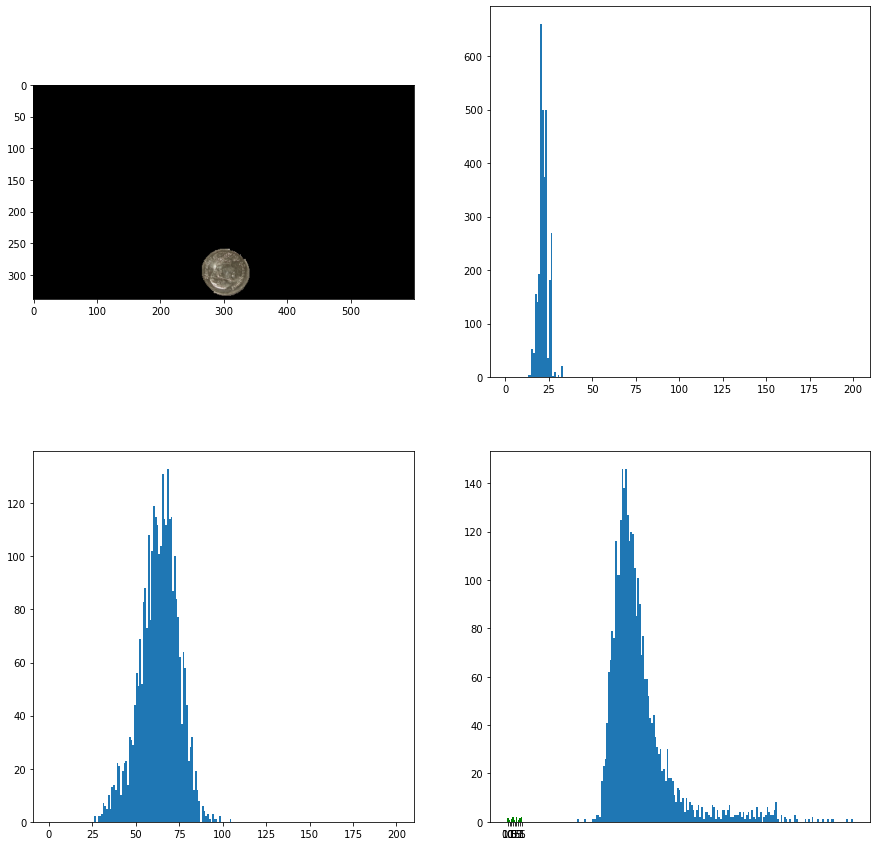

In [301]:
img = cv2.imread('assets/Lab6-SampleCoins.jpg'.format(i))
    
    
imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
imgDisp = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

imgTemp = cv2.medianBlur(imgGray.copy(), 13)
print(cv2.THRESH_OTSU)
_,imgTemp = cv2.threshold(imgTemp,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
#     imgTemp = cv2.adaptiveThreshold(imgTemp,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY_INV,101,2)
#     imgTemp = cv2.medianBlur(imgTemp, 11)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# imgTemp = cv2.morphologyEx(imgTemp, cv2.MORPH_CLOSE, kernel, iterations = 6)

imgTemp = cv2.distanceTransform(imgTemp, cv2.DIST_L2, 3)

_maxDist = np.max(imgTemp)
imgTemp = np.uint8(imgTemp > 0.45*_maxDist)
_, seed = cv2.connectedComponents(imgTemp)
seed[-10:,-10] = np.max(seed) + 1

imgSeg = cv2.watershed(img.copy(), seed)

# plt.imshow(imgSeg, cmap='jet')
# plt.show()
# plt.imshow(imgDisp)
# plt.show()

feat_list = [None]

normfactor = np.sum(imgSeg==3)

for i in range(1,np.max(imgSeg)):
#     print(i)
    disp = imgDisp.copy()
    disp[imgSeg!=i,:] = 0
    _, axarr = plt.subplots(2,2,figsize=(15,15))
    axarr[0,0].imshow(disp, cmap='jet')
    axarr[0,1].hist(hsv[:,:,0].flatten(), range=(1,200),bins=199)
    axarr[1,0].hist(hsv[:,:,1].flatten(), range=(1,200),bins=199)
    axarr[1,1].hist(hsv[:,:,2].flatten(), range=(1,200),bins=199)
    hsv = cv2.cvtColor(disp, cv2.COLOR_RGB2HSV)
    feat = []
    
    hist = np.histogram(hsv[:,:,1].flatten(), range=(1,200), bins=199)[0]
    hist = hist/np.sum(hist)
    feat += list(hist)
    
#     hist = np.histogram(hsv[:,:,0].flatten(), range=(1,200), bins=64)[0]
#     hist = hist*0.5/np.sum(hist)
#     feat += list(hist)
    
    size = np.sum(imgSeg==i)
    feat += [size/normfactor]
    
    feat_list.append(feat)
#     plt.show()

x = list(idx2coin.values())
sizes = []
x_pos = [i for i, _ in enumerate(x)]


print(normfactor)
for i in range(1,np.max(imgSeg)):
    size = np.sum(imgSeg==i)
    sizes.append(size/normfactor)
plt.bar(x_pos, sizes, color='green')
plt.xticks(x_pos, x)
plt.show()


In [296]:
ref_feat_list = list(feat_list)

In [292]:
for idx, coin in idx2coin.items():
#     print('coin:', coin)
    m = 1
    midx = -1
    for idx2, coin2 in idx2coin.items():
        if idx != idx2:
            d = np.linalg.norm(np.array(feat_list[idx])- np.array(feat_list[idx2]))
            if d < m:
                m = d
                midx = idx2
    print('{} - {}'.format(coin, idx2coin.get(midx, 'No result')))

10 - 1
0.5 - 0.5
1 - 0.5
5 - 5
0.5 - 0.5
5 - 5
0.5 - 1
1 - 10
1 - 5


## Detection Algorithm

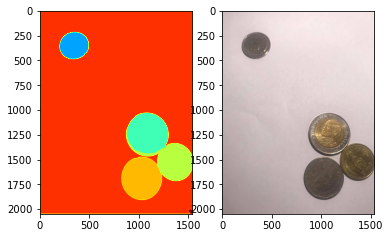

total: 7.5


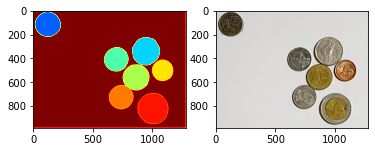

total: 14.5


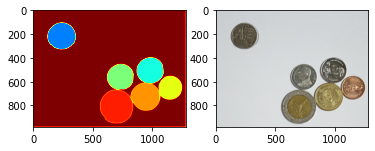

total: 13.0


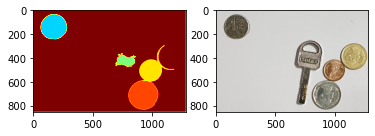

total: 3.0


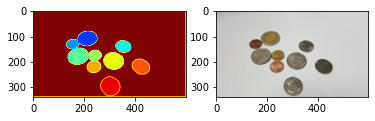

total: 7.0


In [321]:
### FILL HERE ###
for i in ['MyCoin2','AssignmentC1','AssignmentC2','AssignmentC3','SampleCoins']:
    
    value = 0
    
    img = cv2.imread('assets/Lab6-{}.jpg'.format(i))
    
    
    imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     imgGray[imgGray < 155] = 125
    imgDisp = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     plt.imshow(imgGray, cmap='gray')
    imgTemp = cv2.medianBlur(imgGray.copy(), 13)
    _,imgTemp = cv2.threshold(imgTemp,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
#     imgTemp = cv2.adaptiveThreshold(imgTemp,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY_INV,101,2)
#     imgTemp = cv2.medianBlur(imgTemp, 11)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    imgTemp = cv2.morphologyEx(imgTemp, cv2.MORPH_CLOSE, kernel, iterations = 6)
    
    imgTemp = cv2.distanceTransform(imgTemp, cv2.DIST_L2, 3)
    
    _maxDist = np.max(imgTemp)
    imgTemp = np.uint8(imgTemp > 0.45*_maxDist)
    _, seed = cv2.connectedComponents(imgTemp)
    seed[-10:,-10] = np.max(seed) + 1

    imgSeg = cv2.watershed(img.copy(), seed)
    
    _, axarr = plt.subplots(1,2)
    axarr[0].imshow(imgSeg, cmap='jet')
    axarr[1].imshow(imgDisp, cmap='gray')
    plt.show()
    
    normfactor = np.sum(imgSeg==1)
    
    for i in range(1,np.max(imgSeg)):
        disp = imgDisp.copy()
        disp[imgSeg!=i,:] = 0
        hsv = cv2.cvtColor(disp, cv2.COLOR_RGB2HSV)
        feat = []

        hist = np.histogram(hsv[:,:,1].flatten(), range=(1,200), bins=199)[0]
        hist = hist/np.sum(hist)
        feat += list(hist)

#         hist = np.histogram(hsv[:,:,0].flatten(), range=(1,200), bins=64)[0]
#         hist = hist*0.5/np.sum(hist)
#         feat += list(hist)

        size = np.sum(imgSeg==i)
        feat += [size/normfactor]

        feat_list.append(feat)
        m = 2
        midx = -1
        for idx2, coin2 in idx2coin.items():
            d = np.linalg.norm(np.array(ref_feat_list[idx2])- np.array(feat))
            if d < m:
                m = d
                midx = idx2
        value += idx2coin.get(midx,0)
    print("total:",value)
        
        
    